In [14]:
# import necessary libraries
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision.transforms import Lambda

In [44]:
class UltrasoundDataset(Dataset):
    '''
    Custom dataset class for ultrasound images
    '''
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join('..',self.dataframe.iloc[idx, 0])

        image = Image.open(img_name)
        if image.mode == 'RGBA':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx, 1]
        return image, label

In [45]:
# Define the preprocessing transforms
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    #grayscale to RGB since the model was trained on RGB images
    Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
    # Normalize the image using the mean and standard deviation of the ImageNet dataset
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataframe
df_path = os.path.join('..','Dataset_BUSI_with_GT','dataset.csv')
df = pd.read_csv(df_path)

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create the training and validation datasets
train_dataset = UltrasoundDataset(train_df, transform=transforms)
val_dataset = UltrasoundDataset(val_df, transform=transforms)

# Create the training and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

#print train and validation dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 624
Validation dataset size: 157


Original class labels values count
0  - Normal
1  - Benign
2  - Malignant


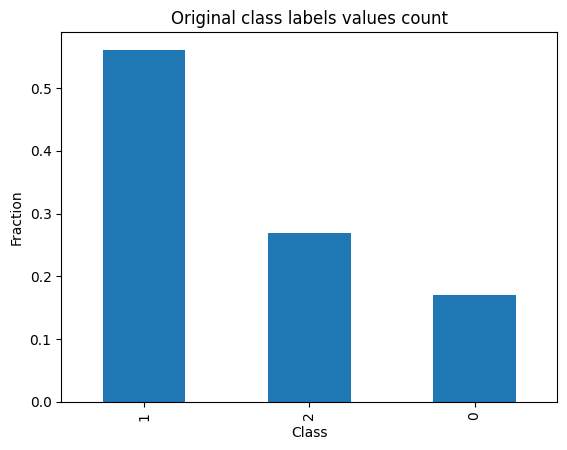

In [46]:
print("Original class labels values count")
print(0, ' - Normal')
print(1, ' - Benign')
print(2, ' - Malignant')
df['true_label_num'].value_counts(normalize=True).plot(kind='bar', title='Original class labels values count',xlabel='Class', ylabel='Fraction')
plt.show()

In [85]:
class ClassificationTrainer:
    def __init__(self, model,epochs, criterion, optimizer,
                 train_dataloader,val_dataloader,model_save_dir, displ_print=True, pbar_visible=False):
        # attributes
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.epochs = epochs
        self.val_data_loader = val_dataloader
        self.model_save_dir = model_save_dir
        self.displ_print = displ_print
        self.pbar_visible = pbar_visible


        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # self.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        # send model to device
        self.model.to(self.device)

        # check if model directory exits, otherwise create one
        if not os.path.exists(self.model_save_dir):
            os.makedirs(self.model_save_dir)


    def train(self):
        # put model in train mode
        self.model.train()

        with tqdm(range(self.epochs),disable=not self.pbar_visible) as pbar:
            for epoch in pbar:
                # running sum of loss and accuracy
                loss_list = []
                acc_list = []
                for i, (img, label) in enumerate(self.train_dataloader):
                    # set gradient to zero
                    self.optimizer.zero_grad()

                    # send to device
                    img = img.to(self.device)       # [batch_size, 3, 256, 256]
                    label = label.to(self.device)   # [batch_size,]

                    # forward pass
                    output = self.model(img)        # output: [batch_size, 3]
                    
                    loss = self.criterion(output, label)

                    # backward pass
                    loss.backward()

                    self.optimizer.step()

                    # calculate and add 
                    acc = accuracy_score(label.detach().cpu().numpy(),
                                          torch.argmax(torch.softmax(output,dim=-1),dim=-1).detach().cpu().numpy())
                    
                    # append loss and accuracy
                    loss_list.append(loss.item())
                    acc_list.append(acc)
                
                # calculate validation loss and accuracy
                val_loss, val_acc = self.validate()

                # calculate train loss and accuracy
                loss_list = torch.tensor(loss_list)
                acc_list = torch.tensor(acc_list)
                train_loss = torch.mean(loss_list)
                train_acc = torch.mean(acc_list)

                # # take schedular step
                # self.lr_scheduler.step()

                if self.displ_print:
                    print(f'Epoch {epoch} Train Loss: {train_loss} Train Accuracy: {train_acc}, Val Loss: {val_loss}, Val Accuracy: {val_acc}')
                pbar.set_description(f'Train Loss: {train_loss}, Val Loss: {val_loss}')
                pbar.update(1)

            # save model
            torch.save(self.model, os.path.join(self.model_save_dir, 'model.pth'))

    
    def validate(self):

        # put model in eval mode
        self.model.eval()

        # keep list of true and predicted labels
        y_true = []
        y_pred = []
        loss_list = []

        with torch.no_grad():
            for i, (img, label) in enumerate(self.val_data_loader):
                # send image to device
                img = img.to(self.device)    # [batch_size, 3, 256, 256]
                label = label.to(self.device)   # [batch_size,]

                # forward pass
                output = self.model(img)    # [batch_size, 1]

                # y_true
                y_true.extend(label.cpu().numpy().tolist())

                # y_pred
                y_pred.extend(torch.argmax(torch.softmax(output,dim=-1),dim=-1).detach().cpu().numpy())

                # calculate loss
                loss_ = self.criterion(output, label).item()

                loss_list.append(loss_)

        # calculate loss
        loss_list = torch.tensor(loss_list)
        loss = torch.mean(loss_list)

        # calculate accuracy
        acc = accuracy_score(y_true, y_pred)

        # put model back in train mode
        self.model.train()

        return loss, acc
         

In [87]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')

model = torch.nn.Sequential(
    resnet50,
    torch.nn.Linear(1000, 3)
)

# freeze resnet layers
for param in model[0].parameters():
    param.requires_grad = False

# unfreeze last layer
for param in model[0].fc.parameters():
    param.requires_grad = True

# move model to device
model = model.to(DEVICE)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trainer = ClassificationTrainer(
    model=model, epochs=10, criterion=criterion, optimizer=optimizer,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    model_save_dir='ResNet50' ,pbar_visible=False, displ_print=True)

In [88]:
trainer.train()

Epoch 0 Train Loss: 1.046754002571106 Train Accuracy: 0.5528846383094788, Val Loss: 0.9546747207641602, Val Accuracy: 0.554140127388535
Epoch 1 Train Loss: 0.7982975840568542 Train Accuracy: 0.6458333134651184, Val Loss: 0.8361705541610718, Val Accuracy: 0.6305732484076433
Epoch 2 Train Loss: 0.7555207014083862 Train Accuracy: 0.6650640964508057, Val Loss: 0.8701872825622559, Val Accuracy: 0.6178343949044586
Epoch 3 Train Loss: 0.6261671781539917 Train Accuracy: 0.7483974099159241, Val Loss: 0.9891783595085144, Val Accuracy: 0.5668789808917197
Epoch 4 Train Loss: 0.641977846622467 Train Accuracy: 0.7355769276618958, Val Loss: 0.7649283409118652, Val Accuracy: 0.6942675159235668
Epoch 5 Train Loss: 0.5996412038803101 Train Accuracy: 0.745192289352417, Val Loss: 1.0178526639938354, Val Accuracy: 0.6178343949044586
Epoch 6 Train Loss: 0.5795695781707764 Train Accuracy: 0.7596153616905212, Val Loss: 1.0113518238067627, Val Accuracy: 0.6114649681528662
Epoch 7 Train Loss: 0.5374721884727478